In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d
import glob

In [2]:
wind_path = '/data/users/kgruber/Data/era5/BRA/eff_ws'
dpath = '/data/users/kgruber/other-data/BRA'
base_path = '/data/users/kgruber/other-data/BRA_turbine_locations'
results_path = '/data/users/kgruber/results/BRA_turbine_locations'

In [3]:
wind = xr.open_mfdataset(wind_path + '/era5_wind_BRA_*.nc',chunks={'time':30})

In [4]:
wp_twp = pd.read_csv(dpath + '/windparks_TWP.csv',header=0,index_col = 0)

In [5]:
states_NE = ['Paraíba','Rio Grande do Norte','Bahia','Ceará','Sergipe','Pernambuco','Piaui','Maranhão']

In [6]:
lons = wp_twp.long[[s in states_NE for s in wp_twp.state.values]]
lats = wp_twp.lat[[s in states_NE for s in wp_twp.state.values]]
wpyears = wp_twp.year[[s in states_NE for s in wp_twp.state.values]]
wpcap = wp_twp.cap[[s in states_NE for s in wp_twp.state.values]]

In [7]:
print('lons',lons.min(),lons.max())
print('lats',lats.min(),lats.max())

lons -44.86525 -34.8599722222222
lats -16.450222222222198 -1.81372222222222


In [8]:
wind_NE = wind.sel(latitude=slice(-1,-17),longitude=slice(-45,-34))

In [9]:
print(len(wind_NE.latitude)*len(wind_NE.longitude),'gridcells')

2405 gridcells


In [10]:
gen_NE_csv = pd.read_csv(base_path + '/hourly_generation_NE.csv',
                         sep=';',index_col=0,usecols=[0,7],
                         parse_dates=True,dayfirst=True).rename(columns={'Selecione Tipo de GE Simp 4':'gen'})[1:]
# remove duplicate time stamps
gen_NE_csv = gen_NE_csv.loc[~gen_NE_csv.index.duplicated(keep='first')]


# data are not in right order and some lines are missing... therefore sort and interpolate missing values
#gen_NE_csvs = gen_NE_csv.sort_index()
# insert in full time series and fill in missing data
dr = pd.date_range(start=gen_NE_csv.index.min(),end=gen_NE_csv.index.max(),freq='H')
gen_NE = pd.DataFrame({'gen':dr.map(gen_NE_csv.gen)},index=dr).interpolate()
gen_NExr = gen_NE.to_xarray().rename({'index':'time'})

In [11]:
def corr_gr_ts(gr,ts):
    '''
    calculating correlation between one time series (ts)
    and time series in a grid (gr)
    
    both are provided as xarray DataArray with time axis
    correlation is calculated according to:
    cor = mean((xr-mean(xr))*(ts-mean(ts)))/(sqrt(var(xr))*sqrt(var(ts)))
    '''
    Egr = gr - gr.mean('time')
    Ets = ts - ts.mean('time')
    std_gr = (gr.var('time'))**0.5
    std_ts = (ts.var())**0.5
    
    return((Egr*Ets).mean('time')/(std_gr*std_ts))

## Correlate wind speeds

In [296]:
if(results_path + '/cor_wind_wp.nc' ! in glob.glob(results_path + '/*.nc')):
    # for 2006 not entire year
    c = [corr_gr_ts(wind_NE.wh100.sel(time=gen_NExr.gen.sel(time='2006').time.values),
                    gen_NExr.gen.sel(time='2006'))]
    # for 2007 to 2018
    for year in range(2007,2019):
        c = c + [corr_gr_ts(wind_NE.wh100.sel(time=str(year)),
                            gen_NExr.gen.sel(time=str(year)))]

    ind =  xr.DataArray(np.arange(2006,2019), coords=[np.arange(2006,2019)], dims=['year'],name='year')
    cy = xr.concat(c,dim=ind).compute()

    cy.to_netcdf(results_path + '/cor_wind_wp.nc')

In [19]:
cy = xr.open_dataset(results_path + '/cor_wind_wp.nc').__xarray_dataarray_variable__

In [ ]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.2,wspace=0.15)

year = 2006
clon = cy.longitude[range(0,len(cy.longitude),10)]
clat = cy.latitude[range(6,len(cy.latitude),10)]

for ind in range(1,14):
    plt.subplot(4, 4, ind)
    cy.sel(year=year).plot(cmap='coolwarm')
    plt.scatter(lons,lats,color='black',s=10,alpha=0.5)
    if ind < 10:
        plt.xlabel('')
        plt.xticks(clon, " ")
    if (ind % 4) != 1:
        plt.ylabel('')
        plt.yticks(clat, " ")
    year = year + 1
plt.show()

plot only wind parks where were installed in that year

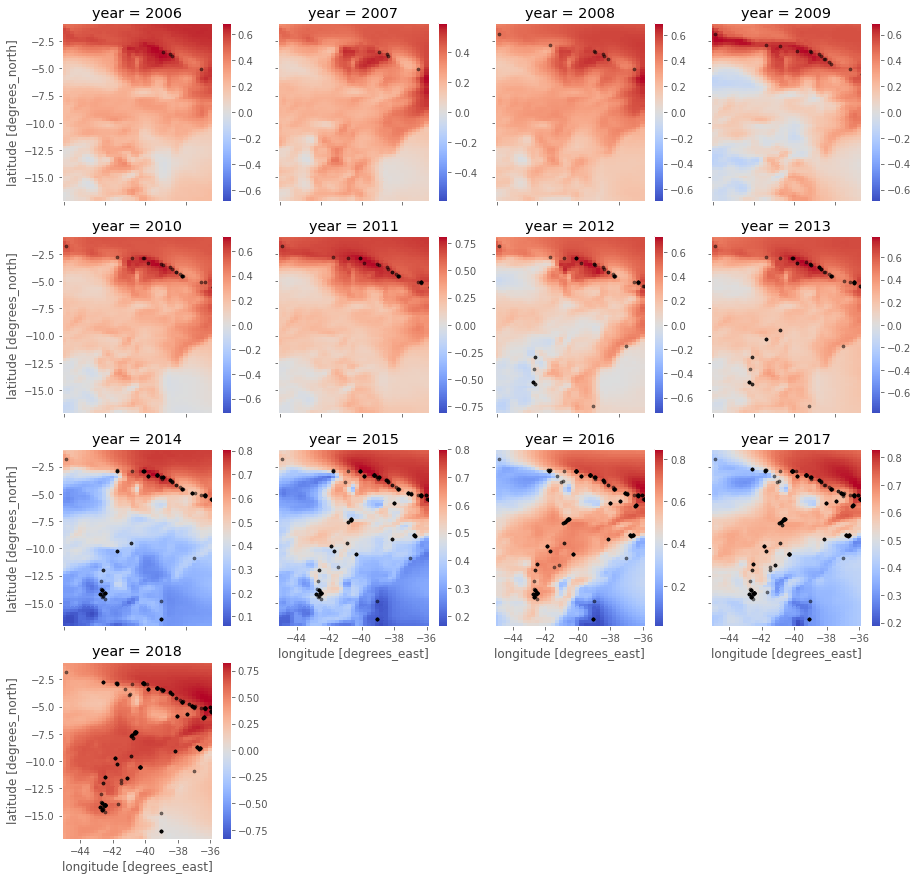

In [415]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.2,wspace=0.15)

year = 2006
clon = cy.longitude[range(0,len(cy.longitude),10)]
clat = cy.latitude[range(6,len(cy.latitude),10)]

for ind in range(1,14):
    plt.subplot(4, 4, ind)
    cy.sel(year=year).plot(cmap='coolwarm')
    plt.scatter(lons[wpyears<=year],lats[wpyears<=year],color='black',s=10,alpha=0.5)
    if ind < 10:
        plt.xlabel('')
        plt.xticks(clon, " ")
    if (ind % 4) != 1:
        plt.ylabel('')
        plt.yticks(clat, " ")
    year = year + 1
plt.show()

histogram of correlations and correlations only on cells with turbines

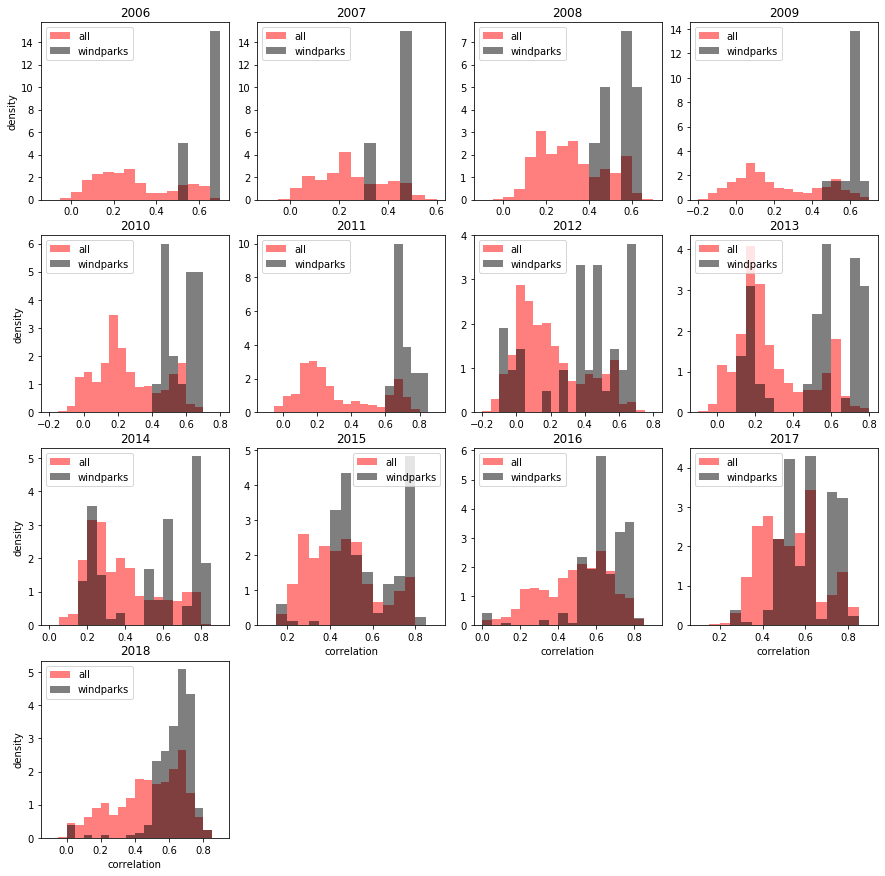

In [87]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.2,wspace=0.15)

y = 2006
for ind in range(1,14):
    plt.subplot(4, 4, ind)
    lower = np.round((cy.sel(year=y).min()-0.05),1).values
    upper = np.round((cy.sel(year=y).max()+0.05),1).values
    bins = int(round((upper-lower)*10)*2)
    cy.sel(year=y).plot.hist(color='red',alpha=0.5,label='all',range=(lower,upper),bins=bins,density=True)
    cy.sel(year=y).interp(coords={"longitude":xr.DataArray(lons[wpyears<=y],dims='location'),
                                  "latitude":xr.DataArray(lats[wpyears<=y],dims='location')},
                             method="nearest").drop(['longitude','latitude']).plot.hist(color='black',
                                                                                        alpha=0.5,
                                                                                        label='windparks',range=(lower,upper),bins=bins,density=True)
    if(ind >=10):
        plt.xlabel('correlation')
    else:
        plt.xlabel('')
    if (ind % 4) == 1:
        plt.ylabel('density')
    plt.title(y)
    plt.legend()
    
    y = y + 1

plot installed capacity vs correlation

In [119]:
# find unique points
locs= xr.DataArray(np.arange(len(cy.longitude)*len(cy.latitude)).reshape(len(cy.longitude),len(cy.latitude)),
                   dims = ['longitude','latitude'],
                   coords = {'longitude':cy.longitude.values,
                             'latitude':cy.latitude.values})

# interpolate to points
loci = locs.interp(coords={"longitude":xr.DataArray(lons,dims='location'),
                           "latitude":xr.DataArray(lats,dims='location')},
                   method="nearest").to_dataframe(name='loc')
# insert capacities
loci['cap'] = wpcap
loci['year'] = wpyears
# aggregate per point and year
locia = loci.dropna().groupby(['loc','year']).sum().reset_index()
locia['latitude'] = loci.dropna().groupby(['loc','year']).first().latitude.values
locia['longitude'] = loci.dropna().groupby(['loc','year']).first().longitude.values

In [ ]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.2,wspace=0.15)

y = 2006
for ind in range(1,14):
    locy = locia[locia.year <= y]
    
    locya  = locy.groupby(['loc']).first()
    locya['cap'] = locy.groupby(['loc']).sum().cap.values
    
    plt.subplot(4, 4, ind)
    caps = locya.cap
    cors = cy.sel(year=y).interp(coords={"longitude":xr.DataArray(locya.longitude,dims='location'),
                                  "latitude":xr.DataArray(locya.latitude,dims='location')},
                             method="nearest").drop(['longitude','latitude']).values
    plt.scatter(caps/10**3,cors)
    if(ind >=10):
        plt.xlabel('capacity MW')
    else:
        plt.xlabel('')
    if (ind % 4) == 1:
        plt.ylabel('correlation')
    plt.title(y)
    
    y = y + 1

## Correlate v³ + cutout

In [403]:
(wind_NE.wh100>25).sum().compute()

/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


<xarray.DataArray 'wh100' ()>
array(2650)

In [404]:
if(results_path + '/cor_v3_wp.nc' ! in glob.glob(results_path + '/*.nc')):
    wind3_NE = wind_NE.wh100.where(wind_NE.wh100<=25,0)**3

    # for 2006 not entire year
    c3 = [corr_gr_ts(wind3_NE.sel(time=gen_NExr.gen.sel(time='2006').time.values),
                     gen_NExr.gen.sel(time='2006'))]
    # for 2007 to 2018
    for year in range(2007,2019):
        c3 = c3 + [corr_gr_ts(wind3_NE.sel(time=str(year)),
                             gen_NExr.gen.sel(time=str(year)))]

    ind =  xr.DataArray(np.arange(2006,2019), coords=[np.arange(2006,2019)], dims=['year'],name='year')
    cy3 = xr.concat(c3,dim=ind).compute()

    cy3.to_netcdf(results_path + '/cor_v3_wp.nc')

In [88]:
cy3 = xr.open_dataarray(results_path + '/cor_v3_wp.nc')

In [ ]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.2,wspace=0.15)

year = 2006
clon = cy3.longitude[range(0,len(cy3.longitude),10)]
clat = cy3.latitude[range(6,len(cy3.latitude),10)]

for ind in range(1,14):
    plt.subplot(4, 4, ind)
    cy3.sel(year=year).plot(cmap='coolwarm')
    plt.scatter(lons,lats,color='black',s=10,alpha=0.5)
    if ind < 10:
        plt.xlabel('')
        plt.xticks(clon, " ")
    if (ind % 4) != 1:
        plt.ylabel('')
        plt.yticks(clat, " ")
    year = year + 1
plt.show()

only plot turbines that were already installed

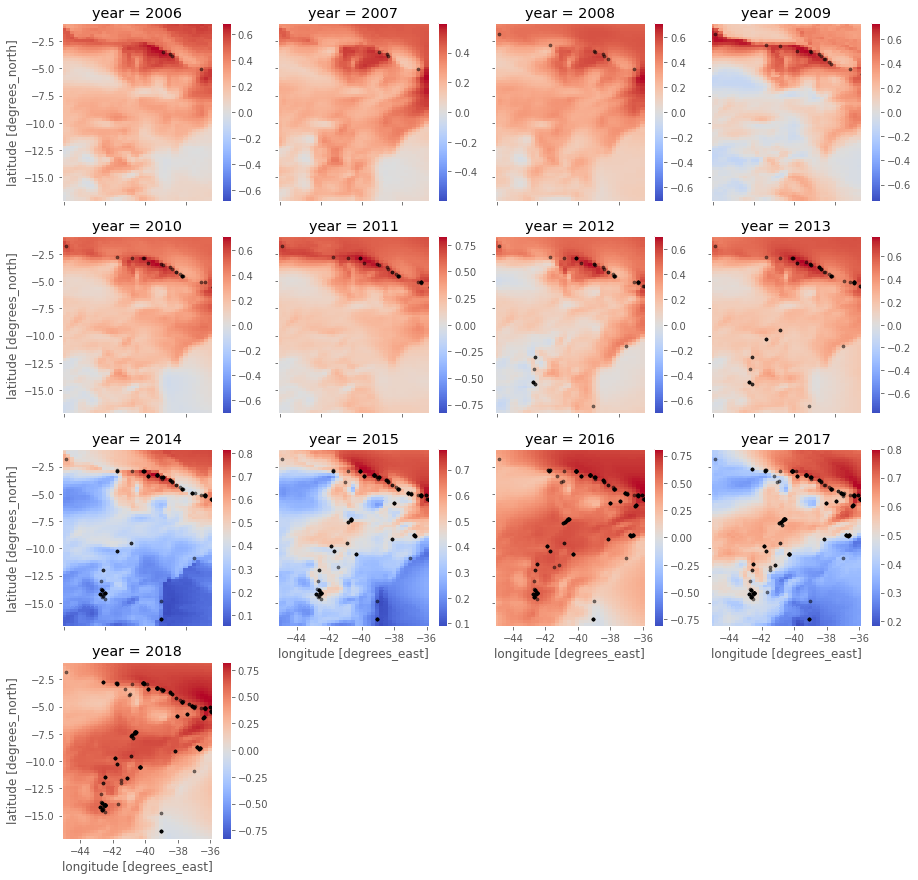

In [416]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.2,wspace=0.15)

year = 2006
clon = cy3.longitude[range(0,len(cy3.longitude),10)]
clat = cy3.latitude[range(6,len(cy3.latitude),10)]

for ind in range(1,14):
    plt.subplot(4, 4, ind)
    cy3.sel(year=year).plot(cmap='coolwarm')
    plt.scatter(lons[wpyears<=year],lats[wpyears<=year],color='black',s=10,alpha=0.5)
    if ind < 10:
        plt.xlabel('')
        plt.xticks(clon, " ")
    if (ind % 4) != 1:
        plt.ylabel('')
        plt.yticks(clat, " ")
    year = year + 1
plt.show()

In [ ]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.2,wspace=0.15)

y = 2006
for ind in range(1,14):
    plt.subplot(4, 4, ind)
    lower = np.round((cy3.sel(year=y).min()-0.05),1).values
    upper = np.round((cy3.sel(year=y).max()+0.05),1).values
    bins = int(round((upper-lower)*10)*2)
    cy3.sel(year=y).plot.hist(color='red',alpha=0.5,label='all',range=(lower,upper),bins=bins,density=True)
    cy3.sel(year=y).interp(coords={"longitude":xr.DataArray(lons[wpyears<=y],dims='location'),
                                  "latitude":xr.DataArray(lats[wpyears<=y],dims='location')},
                             method="nearest").drop(['longitude','latitude']).plot.hist(color='black',
                                                                                        alpha=0.5,
                                                                                        label='windparks',range=(lower,upper),bins=bins,density=True)
    if(ind >=10):
        plt.xlabel('correlation')
    else:
        plt.xlabel('')
    if (ind % 4) == 1:
        plt.ylabel('density')
    plt.title(y)
    plt.legend()
    
    y = y + 1

In [ ]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.2,wspace=0.15)

y = 2006
for ind in range(1,14):
    locy = locia[locia.year <= y]
    
    locya  = locy.groupby(['loc']).first()
    locya['cap'] = locy.groupby(['loc']).sum().cap.values
    
    plt.subplot(4, 4, ind)
    caps = locya.cap
    cors = cy3.sel(year=y).interp(coords={"longitude":xr.DataArray(locya.longitude,dims='location'),
                                          "latitude":xr.DataArray(locya.latitude,dims='location')},
                                  method="nearest").drop(['longitude','latitude']).values
    plt.scatter(caps/10**3,cors)
    if(ind >=10):
        plt.xlabel('capacity MW')
    else:
        plt.xlabel('')
    if (ind % 4) == 1:
        plt.ylabel('correlation')
    plt.title(y)
    
    y = y + 1

# Regression model

##### for entire grid 2018

In [11]:
ll = np.array(np.meshgrid(wind_NE.latitude, wind_NE.longitude)).reshape(2, len(wind_NE.latitude)*len(wind_NE.longitude))

In [12]:
wi = wind_NE.interp(coords={'latitude':xr.DataArray(ll[0],dims='loc'),
                       'longitude':xr.DataArray(ll[1],dims='loc')},method='nearest').drop(['longitude','latitude'])

In [488]:
res[0].reshape(len(wind_NE.latitude),len(wind_NE.longitude)).shape

(65, 37)

In [470]:
t1 = datetime.datetime.now()
res = np.linalg.lstsq(wi.wh100.transpose('time','loc').sel(time='2018'),gen_NExr.gen.sel(time='2018'))
t2 = datetime.datetime.now()
print(t2-t1)

/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


0:00:03.274759


In [485]:
cc_res = xr.DataArray(res[0].reshape(len(wind_NE.latitude),len(wind_NE.longitude)),
                      dims=['lat','lon'],
                      coords={'lat':wind_NE.latitude.values,'lon':wind_NE.longitude.values})

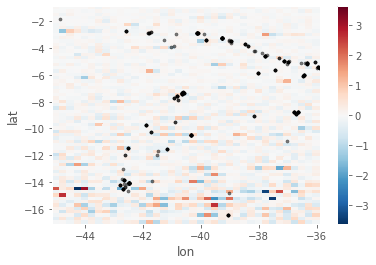

In [487]:
cc_res.transpose('lat','lon').plot()
plt.scatter(lons[wpyears<=2018],lats[wpyears<=year],color='black',s=10,alpha=0.5)

In [509]:
est = (xr.DataArray(res[0],dims='loc')*wi.wh100).sum('loc').compute()

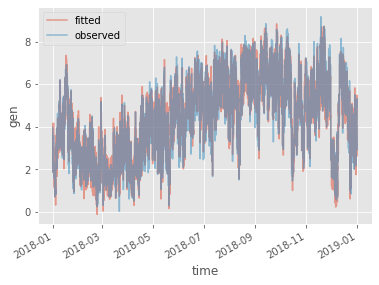

In [513]:
est.sel(time='2018').plot(alpha=0.5,label='fitted')
gen_NExr.gen.sel(time='2018').plot(alpha=0.5,label='observed')
plt.legend()

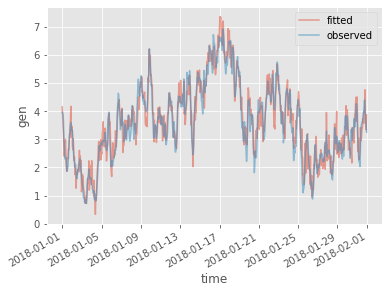

In [519]:
est.sel(time='2018-01').plot(alpha=0.5,label='fitted')
gen_NExr.gen.sel(time='2018-01').plot(alpha=0.5,label='observed')
plt.legend()

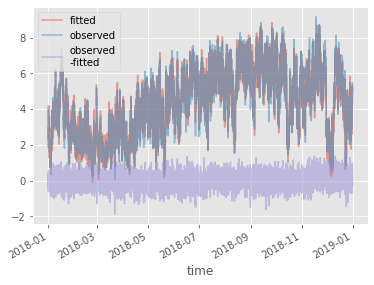

In [515]:
est.sel(time='2018').plot(alpha=0.5,label='fitted')
gen_NExr.gen.sel(time='2018').plot(alpha=0.5,label='observed')
(gen_NExr.gen.sel(time='2018')-est.sel(time='2018')).plot(alpha=0.5,label='observed\n-fitted')
plt.legend()

## entire period

In [466]:
ll = np.array(np.meshgrid(wind_NE.latitude, wind_NE.longitude)).reshape(2, len(wind_NE.latitude)*len(wind_NE.longitude))

In [469]:
wi = wind_NE.interp(coords={'latitude':xr.DataArray(ll[0],dims='loc'),
                       'longitude':xr.DataArray(ll[1],dims='loc')},method='nearest').drop(['longitude','latitude'])

In [534]:
def fit_wp(wind,wp,lats,lons):
    res = np.linalg.lstsq(wind.transpose('time','loc'),wp)[0].reshape(len(lats),
                                                                      len(lons))
    return(xr.DataArray(res,
                       dims=['lat','lon'],
                       coords={'lat':lats,'lon':lons}))

only works for 2018 - all other years it doesn't converge

In [575]:
#for 2006 not entire year
y = []
try:
    y = y + [2006]
    cc_res = [fit_wp(wi.wh100.sel(time=gen_NExr.gen.sel(time='2006').time.values),
                     gen_NExr.gen.sel(time='2006'),
                     wind_NE.latitude.values, wind_NE.longitude.values)]
except:
    y = y[:-1]    

# for 2007 to 2018
for year in range(2007,2019):
    try:
        y = y + [year]
        cc_res = cc_res + [fit_wp(wi.wh100.sel(time=gen_NExr.gen.sel(time=str(year)).time.values),
                                  gen_NExr.gen.sel(time=str(year)),
                                  wind_NE.latitude.values, wind_NE.longitude.values)]
    except:
        y = y[:-1]

/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and 

## v³ + cut-out

In [548]:
wi3 = wind3_NE.interp(coords={'latitude':xr.DataArray(ll[0],dims='loc'),
                              'longitude':xr.DataArray(ll[1],dims='loc')},
                      method='nearest').drop(['longitude','latitude'])

In [577]:
#for 2006 not entire year
y = []
try:
    y = y + [2006]
    cc3_res = [fit_wp(wi3.sel(time=gen_NExr.gen.sel(time='2006').time.values),
                      gen_NExr.gen.sel(time='2006'),
                      wind_NE.latitude.values, wind_NE.longitude.values)]
except:
    y = y[:-1]

# for 2007 to 2018
for year in range(2007,2019):
    try:
        y = y + [year]
        cc3_res = cc3_res + [fit_wp(wi3.sel(time=str(year)),
                                    gen_NExr.gen.sel(time=str(year)),
                                    wind_NE.latitude.values, wind_NE.longitude.values)]
    except:
        y = y[:-1]

/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to kee

In [582]:
ind =  xr.DataArray(np.arange(2006,2019), coords=[np.arange(2006,2019)], dims=['year'],name='year')
cc3y = xr.concat(cc3_res,dim=ind).compute()

In [583]:
cc3y.to_netcdf(results_path + '/beta_v3_wp.nc')

In [ ]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.2,wspace=0.15)

year = 2006
clon = cc3y.lon[range(0,len(cc3y.lon),10)]
clat = cc3y.lat[range(6,len(cc3y.lat),10)]

for ind in range(1,14):
    plt.subplot(4, 4, ind)
    cc3y.sel(year=year).plot(cmap='coolwarm')
    plt.scatter(lons[wpyears<=year],lats[wpyears<=year],color='black',s=10,alpha=0.5)
    if ind < 10:
        plt.xlabel('')
        plt.xticks(clon, " ")
    if (ind % 4) != 1:
        plt.ylabel('')
        plt.yticks(clat, " ")
    year = year + 1
plt.show()

## power curve

In [561]:
# enercon e82 power curve
wind_speeds = (np.arange(0, 26, step=1.0))
generation_kw = [0.0, 0.000000000001, 3.0, 25.0, 82.0, 175.0, 321.0, 532.0, 815.0, 1180.0, 1580.0, 1810.0, 1980.0] + 13 * [2050.0]
    
PC = interp1d(wind_speeds, generation_kw)

In [566]:
wp1 = xr.apply_ufunc(PC, wind_NE.wh100.where(wind_NE.wh100<=25,0),
                     dask='parallelized',
                     output_dtypes=[np.float64])/np.array(generation_kw).max()

In [568]:
wpE82 = wp1.interp(coords={'latitude':xr.DataArray(ll[0],dims='loc'),
                           'longitude':xr.DataArray(ll[1],dims='loc')},
                   method='nearest').drop(['longitude','latitude'])

In [589]:
#for 2006 not entire year
y = []
try:
    y = y + [2006]
    wp_res = [fit_wp(wpE82.sel(time=gen_NExr.gen.sel(time='2006').time.values),
                     gen_NExr.gen.sel(time='2006'),
                     wind_NE.latitude.values, wind_NE.longitude.values)]
except:
    y = y[:-1]

# for 2007 to 2018
for year in range(2007,2019):
    try:
        y = y + [year]
        wp_res = wp_res + [fit_wp(wpE82.sel(time=str(year)),
                                  gen_NExr.gen.sel(time=str(year)),
                                  wind_NE.latitude.values, wind_NE.longitude.values)]
    except:
        y = y[:-1]

/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to kee

In [592]:
ind =  xr.DataArray(np.arange(2006,2019), coords=[np.arange(2006,2019)], dims=['year'],name='year')
wpy = xr.concat(wp_res,dim=ind).compute()

In [593]:
wpy.to_netcdf(results_path + '/beta_E82_wp.nc')

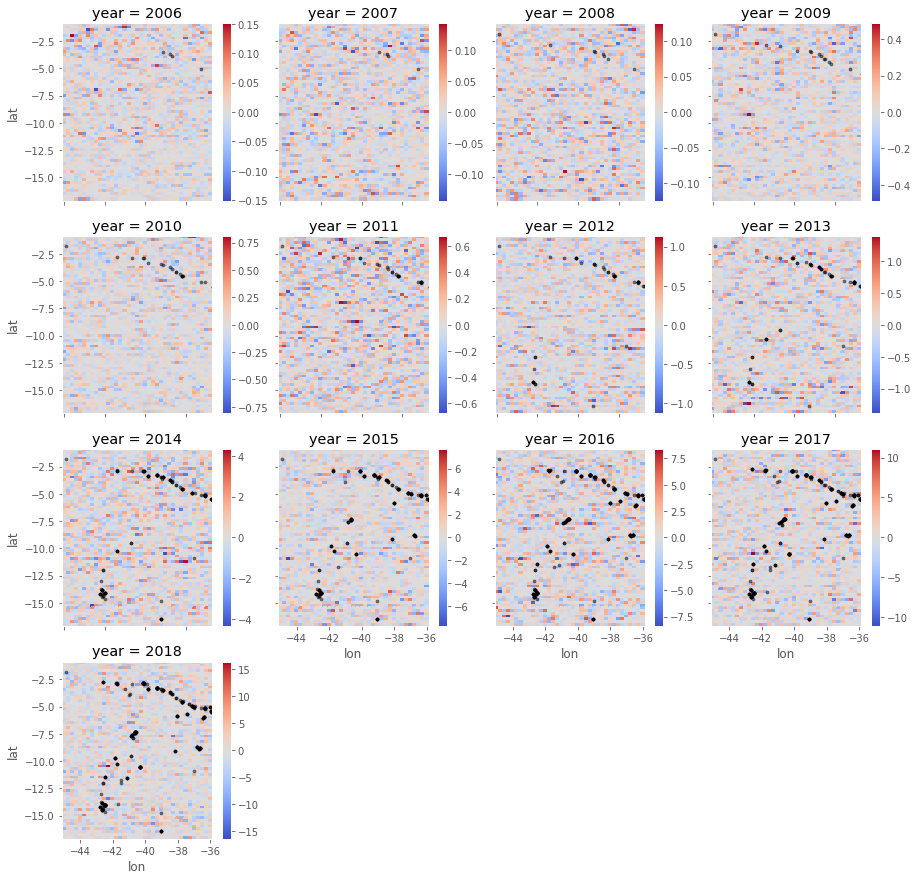

In [594]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.2,wspace=0.15)

year = 2006
clon = wpy.lon[range(0,len(wpy.lon),10)]
clat = wpy.lat[range(6,len(wpy.lat),10)]

for ind in range(1,14):
    plt.subplot(4, 4, ind)
    wpy.sel(year=year).plot(cmap='coolwarm')
    plt.scatter(lons[wpyears<=year],lats[wpyears<=year],color='black',s=10,alpha=0.5)
    if ind < 10:
        plt.xlabel('')
        plt.xticks(clon, " ")
    if (ind % 4) != 1:
        plt.ylabel('')
        plt.yticks(clat, " ")
    year = year + 1
plt.show()